In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.multioutput import MultiOutputRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [3]:
data = pd.read_csv(r"D:\Nouveau dossier\TitreRNCP_Bloc1\projet_prevision_energies_bloc5\datasets\data.csv", 
                   parse_dates=[0], index_col=0)

data.head()

,temp,SOLAR,BIOMASS,WIND_ONSHORE,NUCLEAR,consommation_totale
timestamp,,,,,,
2020-01-01 00:00:00,0.8,0.0,348.0,2810.0,49462.0,63191.75
2020-01-01 01:00:00,-0.7,0.0,347.0,2655.0,49565.0,61903.75
2020-01-01 02:00:00,-0.3,0.0,348.0,2736.0,49580.0,58716.00
2020-01-01 03:00:00,0.0,0.0,348.0,2631.0,49271.0,56448.25
2020-01-01 04:00:00,0.3,0.0,347.0,2533.0,49438.0,55891.00


In [4]:
data.isnull().sum()

temp                   0
SOLAR                  0
BIOMASS                0
WIND_ONSHORE           0
NUCLEAR                0
consommation_totale    0
dtype: int64

In [5]:
data.describe()

,temp,SOLAR,BIOMASS,WIND_ONSHORE,NUCLEAR,consommation_totale
count,50112.000000,50112.000000,50112.000000,50112.000000,50112.000000,50112.000000
mean,13.591303,2230.463681,355.323635,4483.156180,37695.223958,50174.696293
std,7.071711,3276.331904,75.928791,3331.753755,7905.030799,10845.076618
min,-6.400000,0.000000,21.000000,0.000000,0.000000,28768.750000
25%,8.500000,0.000000,326.000000,1975.000000,32433.500000,42152.935000
50%,13.100000,290.000000,346.000000,3412.000000,38558.000000,48187.125000
75%,18.500000,3761.250000,365.000000,6166.250000,42768.000000,57203.312500
max,40.400000,30734.000000,1773.000000,21538.000000,109356.000000,88159.500000


In [6]:
n_futur = 1
lookback = 24

def window_generator(data, lookback, horizon):
    X = []
    y = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i:i+horizon])
    return np.array(X), np.array(y)

In [7]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
X, y = window_generator(data_scaled, lookback, n_futur)
X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [8]:
def create_model(X_train, y_train, X_test, y_test):
    
    mae, mse, r2 = {}, {}, {}
    model_trained = {}
    
    models = {
        "DecisionTreeRegressor": MultiOutputRegressor(DecisionTreeRegressor()),
        "ExtraTreesRegressor": MultiOutputRegressor(ExtraTreesRegressor()),
        "GradientBoostingRegressor": MultiOutputRegressor(GradientBoostingRegressor()),
        "HistGradientBoostingRegressor": MultiOutputRegressor(HistGradientBoostingRegressor()),
        "XGBRegressor": MultiOutputRegressor(XGBRegressor()),
        "LGBMRegressor": MultiOutputRegressor(LGBMRegressor()),
        "CatBoostRegressor": MultiOutputRegressor(CatBoostRegressor())
    }
    
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
        X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])
        
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae[name] = mean_absolute_error(y_test, y_pred)
        mse[name] = mean_squared_error(y_test, y_pred)
        r2[name] = r2_score(y_test, y_pred)
        model_trained[name] = model
    return model_trained, mae, mse, r2

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40070, 24, 6), (10018, 24, 6), (40070, 1, 6), (10018, 1, 6))

In [10]:
y_train = y_train.reshape(-1, len(data.columns))
y_test = y_test.reshape(-1, len(data.columns))
y_train.shape, y_test.shape


((40070, 6), (10018, 6))

In [11]:
model_trained, mae, mse, r2 = create_model(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36720
[LightGBM] [Info] Number of data points in the train set: 40070, number of used features: 144
[LightGBM] [Info] Start training from score 0.425527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36720
[LightGBM] [Info] Number of data points in the train set: 40070, number of used features: 144
[LightGBM] [Info] Start training from score 0.064541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36720
[LightGBM] [Info] Number of data points in the train set: 40070, number of used features: 144
[LightGBM] [Info] Sta

In [13]:
mae = pd.DataFrame(mae, index=["MAE"]).T.sort_values(by="MAE", ascending=True)
mse = pd.DataFrame(mse, index=["MSE"]).T.sort_values(by="MSE", ascending=True)
r2 = pd.DataFrame(r2, index=["R2"]).T.sort_values(by="R2", ascending=False)
df_metrics = pd.concat([mae, mse, r2], axis=1)
df_metrics


,MAE,MSE,R2
ExtraTreesRegressor,0.010006,0.000519,0.949603
CatBoostRegressor,0.010247,0.000538,0.952014
LGBMRegressor,0.010419,0.000544,0.949355
HistGradientBoostingRegressor,0.010479,0.000548,0.949123
XGBRegressor,0.011627,0.000695,0.925381
GradientBoostingRegressor,0.011758,0.000727,0.938505
DecisionTreeRegressor,0.014353,0.001042,0.857140


In [15]:
y_pred = model_trained["ExtraTreesRegressor"].predict(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]))
y_pred_descaled = scaler.inverse_transform(y_pred)
y_test_descaled = scaler.inverse_transform(y_test)


In [17]:
def plot_results(y_pred_descaled, y_test_descaled, rows=5*24, n_col=0, col=0):

    plt.figure(figsize=(10,6))
    plt.plot(y_pred_descaled[:rows, n_col], label="Actual")
    plt.plot(y_test_descaled[:rows, n_col], label="Predicted")
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.title(f"Energy {data.columns[col]} Prediction")
    plt.legend()
    plt.show()

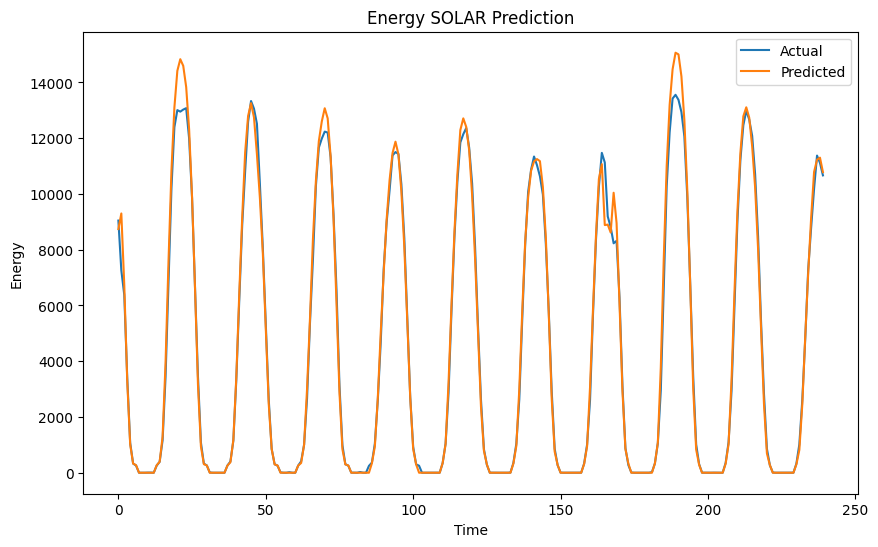

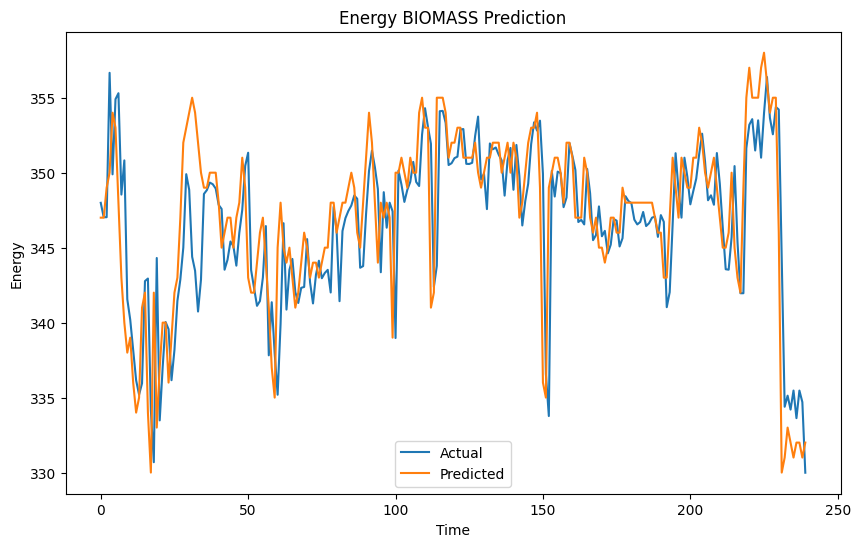

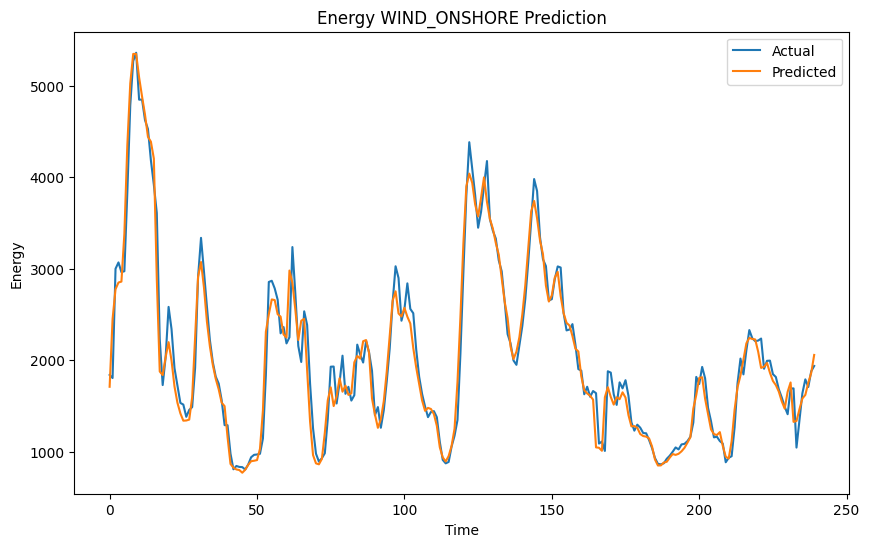

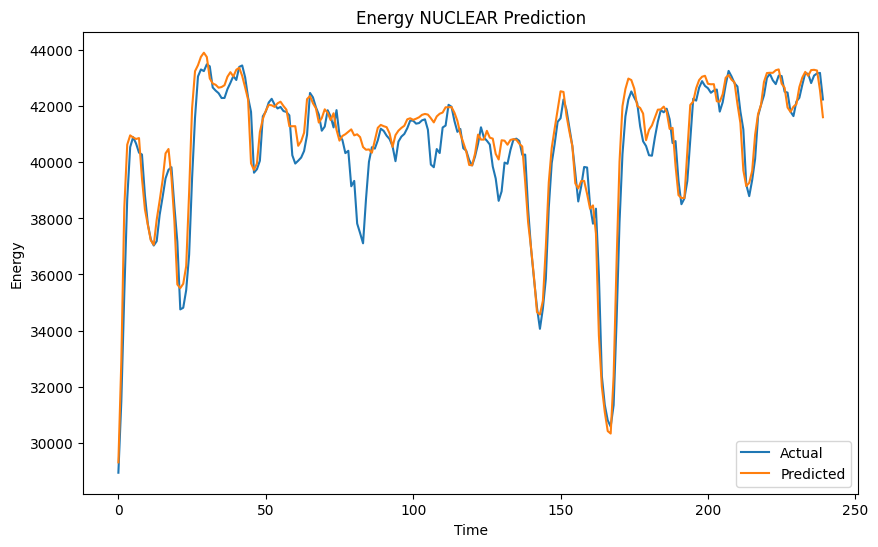

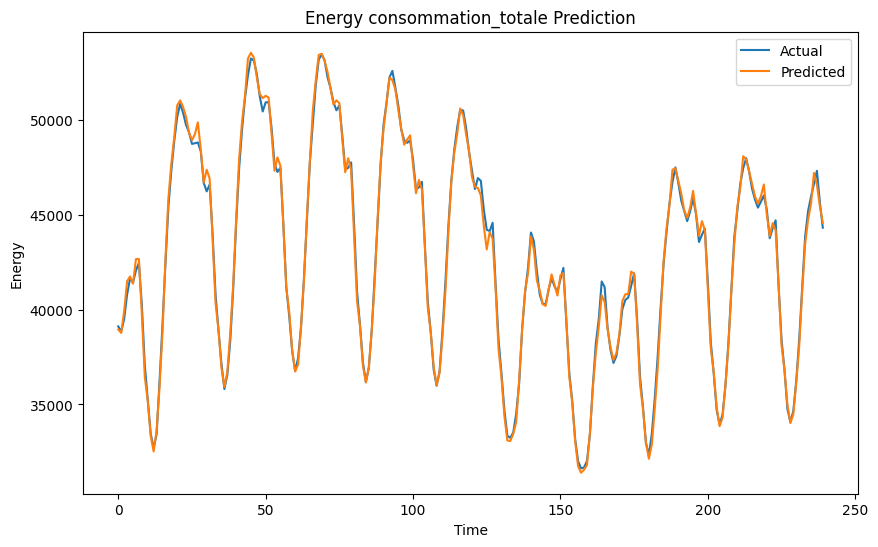

In [18]:
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=1, col=1)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=2, col=2)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=3, col=3)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=4, col=4)
plot_results(y_pred_descaled, y_test_descaled, rows=240, n_col=5, col=5)

### Cross-validation et recherche des meilleurs hyperparamètres

In [ ]:
def cv_search_hyperparameters(X_train, y_train, cv=3):
    
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
    
    cv_split = TimeSeriesSplit(n_splits=cv)
    
    best_models = {}
    best_scores = {}
    
    models = {
        "Gradient Boosting": MultiOutputRegressor(XGBRegressor(tree_method="hist")), 
        "LightGBM": MultiOutputRegressor(LGBMRegressor()),
        "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor()),
    }
    
    params = {
        "Gradient Boosting": {
            'estimator__learning_rate': Real(0.001, 0.1, prior='log-uniform'),
            'estimator__subsample': Real(0.7, 0.85),
            'estimator__n_estimators': Integer(50, 100)
        },
        "LightGBM": {
            'estimator__learning_rate': Real(0.001, 0.1, prior='log-uniform'),
            'estimator__subsample': Real(0.75, 0.85),
            'estimator__n_estimators': Integer(50, 100)
        },
        
        "ExtraTrees": {
            'estimator__n_estimators': Integer(50, 100),
            'estimator__max_depth': Integer(5, 10),
            'estimator__min_samples_split': Integer(2, 5),
            'estimator__min_samples_leaf': Integer(1, 2)
        }
    }
    
    for model_name, model in models.items():
        
        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=params[model_name],
            scoring='neg_mean_absolute_error',
            cv=cv_split,
            n_iter=30,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        bayes_search.fit(X_train, y_train)
        
        best_models[model_name] = bayes_search.best_estimator_
        best_scores[model_name] = bayes_search.best_score_
        
        print(f"Best CV score for {model_name}: {bayes_search.best_score_:.4f}")
        print(f"Best params: {bayes_search.best_params_}\n")
    
    return best_models, best_scores


In [27]:
X_train.shape, y_train.shape

((40070, 24, 6), (40070, 6))

In [35]:
best_models, best_scores = cv_search_hyperparameters(X_train, y_train)

Best CV score for Gradient Boosting: -0.0081
Best params: OrderedDict({'estimator__learning_rate': 0.08146216961026964, 'estimator__n_estimators': 85, 'estimator__subsample': 0.8307477892694822})



KeyError: 'CatBoost'